# Segmentation

## Initialization

In [30]:
# necessary imports
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import re
from tqdm import tqdm
import albumentations as A
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import datetime, os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

Tensorflow ver. 2.8.0


In [31]:
semSegClasses = {  
     0: [0, 0, 0],         # None 
     1: [70, 70, 70],      # Buildings 
     2: [190, 153, 153],   # Fences 
     3: [72, 0, 90],       # Other 
     4: [220, 20, 60],     # Pedestrians 
     5: [153, 153, 153],   # Poles 
     6: [157, 234, 50],    # RoadLines 
     7: [128, 64, 128],    # Roads 
     8: [244, 35, 232],    # Sidewalks 
     9: [107, 142, 35],    # Vegetation 
     10: [0, 0, 255],      # Vehicles 
     11: [102, 102, 156],  # Walls 
     12: [220, 220, 0],    # TrafficSigns
     13: [70, 130, 180]    # Sky
 }

In [37]:
# important for reproducibility
# this allows to generate the same random numbers
SEED = 42
# path to the dataset divided into train and validation
dataset_path = "./"
training_data = "train/input/"
val_data = "valid/input/"
# number of classes
N_CLASSES = 14
# whether depth mask should be added to the network's input 
DEPTH=False

In [38]:
import glob
def sorted_nicely( l ):
    """ Sort the given iterable in the way that humans expect."""
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(l, key = alphanum_key)

names = sorted_nicely(glob.glob1('./carla_images/rgb/000', "*.jpg"))

## Dataset creation

In [34]:
# Split the images into train and validation datasets
ratio=0.8
input_train_files=[]
input_valid_files=[]
output_train_files=[]
output_valid_files=[]
depth_train_files=[]
depth_valid_files=[]

for i in range(8):
  input_path=f'./carla_images/rgb/00{i}'
  output_path=f'./carla_images/seg/00{i}'
  depth_path=f'./carla_images/depth/00{i}'
  input_names = sorted_nicely(glob.glob1(input_path, "*.jpg"))
  output_names = sorted_nicely(glob.glob1(output_path, "*.png"))
  depth_names = sorted_nicely(glob.glob1(depth_path, "*.png"))
  for c in tqdm(range(len(input_names))):
    if(c>ratio*len(input_names)):
      input_valid_files.append(f'{input_path}/{input_names[c]}')
      output_valid_files.append(f'{output_path}/{output_names[c]}')
      depth_valid_files.append(f'{depth_path}/{depth_names[c]}')
    else:
      input_train_files.append(f'{input_path}/{input_names[c]}')
      output_train_files.append(f'{output_path}/{output_names[c]}')
      depth_train_files.append(f'{depth_path}/{depth_names[c]}')

100%|████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<?, ?it/s]


In [35]:
# albumentations transformation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),

    A.ShiftScaleRotate(scale_limit=0, rotate_limit=0.1, shift_limit=0, p=1, border_mode=cv2.BORDER_WRAP),

    A.GaussNoise(p=0.2),
   
    A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

    A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

     A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),     
])

In [36]:
!mkdir "./train" 
!mkdir "./valid" 
!mkdir "./train/input"
!mkdir "./valid/input"
!mkdir "./train/output"
!mkdir "./valid/output"
!mkdir "./train/depth"
!mkdir "./valid/depth"

import shutil
import cv2
from tqdm import tqdm
new_mask=np.zeros((128, 256, 1))
new_depth=np.zeros((128, 256, 1))
for (i,file) in tqdm(enumerate(input_train_files)):
  img=cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
  img=cv2.resize(img, (256, 128))

  mask=cv2.cvtColor(cv2.imread(output_train_files[i]), cv2.COLOR_BGR2RGB)
  mask=cv2.resize(mask, (256, 128))
  

  if(DEPTH):
    depth_mask=cv2.cvtColor(cv2.imread(depth_train_files[i]), cv2.COLOR_BGR2RGB)
    depth_mask=cv2.resize(depth_mask, (256, 128))
  
  for n in range(25):
    if(DEPTH):
      transformed = transform(image=img, masks=[mask, depth_mask])
      transformed_image = transformed['image']
      transformed_mask = transformed['masks'][0]
      transformed_depth = transformed['masks'][1]
    else:
      #transformed={'image': img, 'mask': mask}
      transformed = transform(image=img, mask=mask)
      transformed_image = transformed['image']
      transformed_mask = transformed['mask']
    for key, item in semSegClasses.items():
      new_mask[(transformed_mask==item).all(axis=2)] = key
    
    cv2.imwrite(f'./train/input/{i}_{n}.jpg', transformed_image)
    cv2.imwrite(f'./train/output/{i}_{n}.png', new_mask)
    if(DEPTH):
      cv2.imwrite(f'./train/depth/{i}_{n}.png', transformed_depth)
  
for (i,file) in tqdm(enumerate(input_valid_files)):
  img=cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
  img=cv2.resize(img, (256, 128))
  
  mask=cv2.cvtColor(cv2.imread(output_valid_files[i]), cv2.COLOR_BGR2RGB)
  mask=cv2.resize(mask, (256, 128))

  if(DEPTH):
    depth_mask=cv2.cvtColor(cv2.imread(depth_valid_files[i]), cv2.COLOR_BGR2RGB)
    depth_mask=cv2.resize(depth_mask, (256, 128))
  
  for key, item in semSegClasses.items():
      new_mask[(mask==item).all(axis=2)] = key
  cv2.imwrite(f'./valid/input/{i}_{n}.jpg', img)
  cv2.imwrite(f'./valid/output/{i}_{n}.png', new_mask)
  if(DEPTH):
      cv2.imwrite(f'./valid/depth/{i}_{n}.png', depth_mask)

996it [06:45,  2.46it/s]
241it [00:11, 20.91it/s]


In [39]:
def parse_image(img_path: str) -> dict:
    """Loads an image and its annotation (mask) and return
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image location.

    Returns
    -------
    dict
        Dictionary mapping an image and its mask.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    mask_path = tf.strings.regex_replace(img_path, "input", "output")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.uint8)

    if(DEPTH):
      depth_path = tf.strings.regex_replace(img_path, "output", "depth")
      depth = tf.io.read_file(depth_path)

      depth = tf.image.decode_jpeg(depth, channels=1)
      depth = tf.image.convert_image_dtype(depth, tf.uint8)

      return {'image': image, 'depth_mask': depth, 'segmentation_mask': mask}
    
    return {'image': image, 'segmentation_mask': mask}

In [40]:
from glob import glob
TRAINSET_SIZE = len(glob(dataset_path + training_data + "*.jpg"))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")

VALSET_SIZE = len(glob(dataset_path + val_data + "*.jpg"))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")

The Training Dataset contains 24900 images.
The Validation Dataset contains 241 images.


In [41]:
train_dataset = tf.data.Dataset.list_files(dataset_path + training_data + "*.jpg", seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(dataset_path + val_data + "*.jpg", seed=SEED)
val_dataset = val_dataset.map(parse_image)

In [42]:

@tf.function
def normalize_depth(input_image: tf.Tensor, input_depth: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    """Rescales the pixel values of the images between 0.0 and 1.0
    compared to [0,255] originally.

    Parameters
    ----------
    input_image : tf.Tensor
        Tensorflow tensor containing an image of size [128, 256, 3].
    input_depth : tf.Tensor
        Tensorflow tensor containing a depth mask of size [128, 256, 1].
    input_mask : tf.Tensor
        Tensorflow tensor containing a mask of size [128, 256, 1].

    Returns
    -------
    tuple
        Normalized image and its masks.
    """
    
    input_image = tf.cast(input_image, tf.float32) / 255.0

    return input_image, input_depth, input_mask

@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    """Rescales the pixel values of the images between 0.0 and 1.0
    compared to [0,255] originally.

    Parameters
    ----------
    input_image : tf.Tensor
        Tensorflow tensor containing an image of size [128, 256, 3].
    input_mask : tf.Tensor
        Tensorflow tensor containing a mask of size [128, 256, 1].

    Returns
    -------
    tuple
        Normalized image and its mask.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32)
    return input_image, input_mask

@tf.function
def load_image_train(datapoint: dict) -> tuple:
    """Applies normalization to an input dictionary
    containing a train image and its annotation.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A normalized image and its annotation.
    """
    input_image = datapoint['image']
    input_mask = datapoint['segmentation_mask']
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    if(DEPTH):
      input_depth=datapoint["depth_mask"]
      input_image, input_depth, input_mask = normalize_depth(input_image, input_depth, input_mask)
      return {'input_img': input_image, 'input_depth': input_depth}, input_mask

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

@tf.function
def load_image_test(datapoint: dict) -> tuple:
    """Normalizes a test image and its annotation.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A normalized image and its annotation.
    """
    input_image = datapoint['image']
    input_mask = datapoint['segmentation_mask']

    if(DEPTH):
      input_depth=datapoint["depth_mask"]
      input_image, input_depth, input_mask = normalize_depth(input_image, input_depth, input_mask)
      return {'input_img': input_image, 'input_depth': input_depth}, input_mask

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [43]:
BATCH_SIZE = 32
BUFFER_SIZE = 100

dataset = {"train": train_dataset, "val": val_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])
print(dataset['val'])

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None))>


## Neural Network architecture

In [44]:
import segmentation_models as sm
sm.set_framework('tf.keras')
# Segmentation Models: using `keras` framework.
model = sm.Unet('efficientnetb0', encoder_weights='imagenet', input_shape=(128, 256, 3), classes=14, activation='softmax')

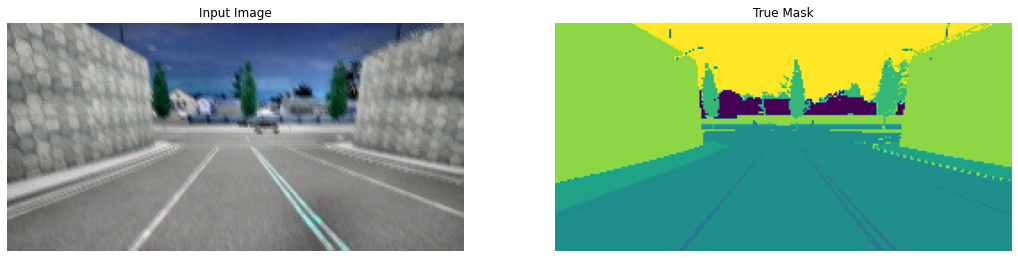

In [45]:
def display_sample(display_list):
    """Shows side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
if(DEPTH):
  for input, mask in dataset['train'].take(1):
      sample_image, sample_mask = input['input_img'], mask
else:
  for image, mask in dataset['train'].take(1):
      sample_image, sample_mask = image, mask

display_sample([sample_image[0], sample_mask[0]])

In [46]:
from tensorflow import keras
# Adding the depth to the input of the network if needed
if(DEPTH):
  input_img=keras.layers.Input(shape=(128, 256, 3), name='input_img')
  depth_img=keras.layers.Input(shape=(128, 256, 1), name='input_depth')
  x=keras.layers.Concatenate(axis=-1)([input_img, depth_img])
  x=keras.layers.Conv2D(3, 3, 1, padding='same', activation='relu')(x)
  i=0
  output=model(x)
  custom_model=keras.Model(inputs=[input_img, depth_img], outputs=output)
else:
  custom_model=model

In [47]:
from keras.losses import SparseCategoricalCrossentropy
custom_model.compile(optimizer = Adam(lr=7e-4, epsilon=1e-8, decay=1e-6), sample_weight_mode = "temporal",
              loss = SparseCategoricalCrossentropy(from_logits=False), metrics = ['accuracy'])

In [48]:
custom_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 64, 128, 32)  864         ['input_2[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 64, 128, 32)  128         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 64, 128, 32)  0           ['stem_bn[0][0]']          

 block2b_bn (BatchNormalization  (None, 32, 64, 144)  576        ['block2b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2b_activation (Activation  (None, 32, 64, 144)  0          ['block2b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2b_se_squeeze (GlobalAver  (None, 144)         0           ['block2b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2b_se_reshape (Reshape)   (None, 1, 1, 144)    0           ['block2b_se_squeeze[0][0]']     
          

                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block3b_se_reshape[0][0]']     
                                                                                                  
 block3b_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block3b_se_reduce[0][0]']      
                                                                                                  
 block3b_se_excite (Multiply)   (None, 16, 32, 240)  0           ['block3b_activation[0][0]',     
                                                                  'block3b_se_expand[0][0]']      
                                                                                                  
 block3b_project_conv (Conv2D)  (None, 16, 32, 40)   9600        ['block3b_se_excite[0][0]']      
                                                                                                  
 block3b_p

 block4b_project_bn (BatchNorma  (None, 8, 16, 80)   320         ['block4b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4b_drop (FixedDropout)    (None, 8, 16, 80)    0           ['block4b_project_bn[0][0]']     
                                                                                                  
 block4b_add (Add)              (None, 8, 16, 80)    0           ['block4b_drop[0][0]',           
                                                                  'block4a_project_bn[0][0]']     
                                                                                                  
 block4c_expand_conv (Conv2D)   (None, 8, 16, 480)   38400       ['block4b_add[0][0]']            
                                                                                                  
 block4c_e

 block5b_expand_bn (BatchNormal  (None, 8, 16, 672)  2688        ['block5b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5b_expand_activation (Act  (None, 8, 16, 672)  0           ['block5b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5b_dwconv (DepthwiseConv2  (None, 8, 16, 672)  16800       ['block5b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5b_bn (BatchNormalization  (None, 8, 16, 672)  2688        ['block5b_dwconv[0][0]']         
 )        

                                                                                                  
 block6a_dwconv (DepthwiseConv2  (None, 4, 8, 672)   16800       ['block6a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6a_bn (BatchNormalization  (None, 4, 8, 672)   2688        ['block6a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6a_activation (Activation  (None, 4, 8, 672)   0           ['block6a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6a_s

 block6c_se_squeeze (GlobalAver  (None, 1152)        0           ['block6c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6c_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6c_se_squeeze[0][0]']     
                                                                                                  
 block6c_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6c_se_reshape[0][0]']     
                                                                                                  
 block6c_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6c_se_reduce[0][0]']      
                                                                                                  
 block6c_se_excite (Multiply)   (None, 4, 8, 1152)   0           ['block6c_activation[0][0]',     
          

 block7a_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block7a_se_reshape[0][0]']     
                                                                                                  
 block7a_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block7a_se_reduce[0][0]']      
                                                                                                  
 block7a_se_excite (Multiply)   (None, 4, 8, 1152)   0           ['block7a_activation[0][0]',     
                                                                  'block7a_se_expand[0][0]']      
                                                                                                  
 block7a_project_conv (Conv2D)  (None, 4, 8, 320)    368640      ['block7a_se_excite[0][0]']      
                                                                                                  
 block7a_project_bn (BatchNorma  (None, 4, 8, 320)   1280        ['block7a_project_conv[0][0]']   
 lization)

                                                                                                  
 decoder_stage2b_bn (BatchNorma  (None, 32, 64, 64)  256         ['decoder_stage2b_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 decoder_stage2b_relu (Activati  (None, 32, 64, 64)  0           ['decoder_stage2b_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 decoder_stage3_upsampling (UpS  (None, 64, 128, 64)  0          ['decoder_stage2b_relu[0][0]']   
 ampling2D)                                                                                       
                                                                                                  
 decoder_s

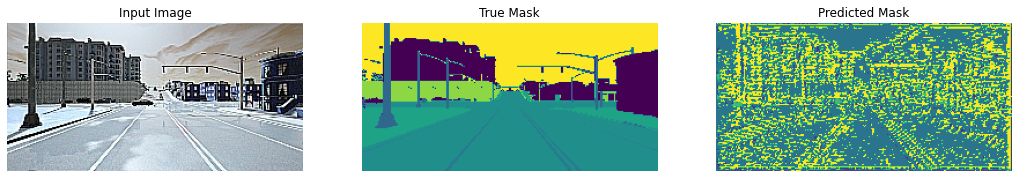

In [49]:
def create_mask(pred_mask):    
    """Returns a filter mask with the top 1 predictions
    only.

    Parameters
    ----------
    pred_mask : tf.Tensor
        A [128, 256, N_CLASS] tensor. For each pixel we have
        N_CLASS values (vector) which represents the probability of the pixel
        being these classes.

    Returns
    -------
    tf.Tensor
        A [128, 256, 1] mask with top 1 predictions
        for each pixels.
    """
    # 1 prediction for each class but we want the highest score only
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask


def show_predictions(dataset=None, num=1):
    """Shows a specific number of sample predictions.

    Parameters
    ----------
    dataset : [type], optional
        Input dataset, by default None
    num : int, optional
        Number of sample to show, by default 1
    """
    if dataset:
      if(DEPTH):
        for input, mask in dataset.take(num):
            pred_mask = custom_model.predict(image)
            display_sample([input['input_img'][0], mask[0], create_mask(pred_mask[0])])
      else:
        for image, mask in dataset.take(num):
            pred_mask = custom_model.predict(image)
            display_sample([image[0], mask[0], create_mask(pred_mask[0])])
    else:
        one_img_batch = sample_image[0][tf.newaxis, ...]
        if(DEPTH):
          one_depth_batch = sample_depth[0][tf.newaxis, ...]
          # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
          inference = custom_model.predict([one_img_batch, one_depth_batch])
        else:
          inference = custom_model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference)
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        display_sample([sample_image[0], sample_mask[0],
                        pred_mask[0]])
if(DEPTH):
  for input, mask in dataset['train'].take(1):
      sample_image, sample_depth, sample_mask = input['input_img'], input['input_depth'], mask
else:
  for image, mask in dataset['train'].take(1):
      sample_image, sample_mask = image, mask
    
show_predictions()

## Training

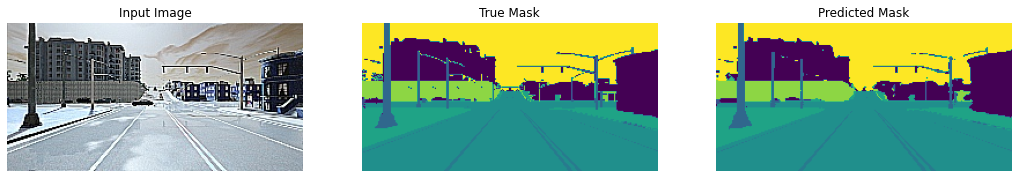


Sample Prediction after epoch 11


Epoch 11: val_loss did not improve from 0.38161
778/778 [==============================] - 162s 208ms/step - loss: 0.0724 - accuracy: 0.9714 - val_loss: 0.6679 - val_accuracy: 0.8823 - lr: 3.5000e-04
Epoch 11: early stopping


In [50]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
EPOCHS = 20
STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [
    # to show samples after each epoch
    DisplayCallback(),
    # to collect some useful metrics and visualize them in tensorboard
    tensorboard_callback,
    # if no accuracy improvements we can stop the training directly
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    # to save checkpoints
    tf.keras.callbacks.ModelCheckpoint('best_model_effnetb0_unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5,)
]
model_history = custom_model.fit(dataset['train'], epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=dataset['val'],
                          callbacks=callbacks)

## Evaluation

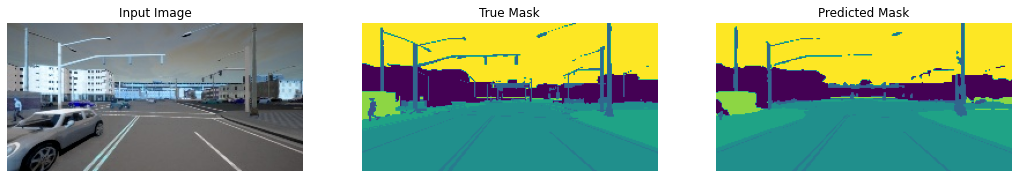

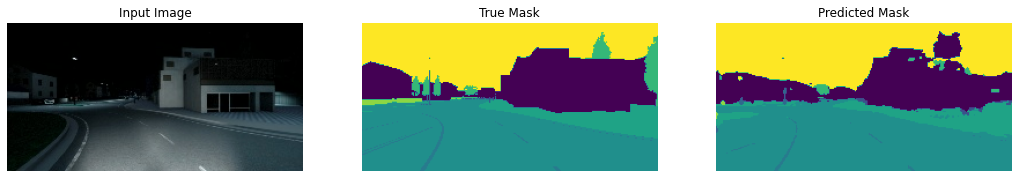

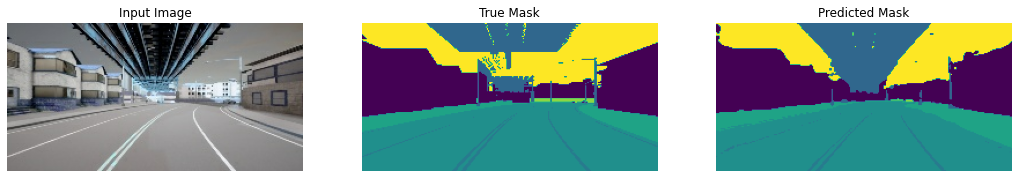

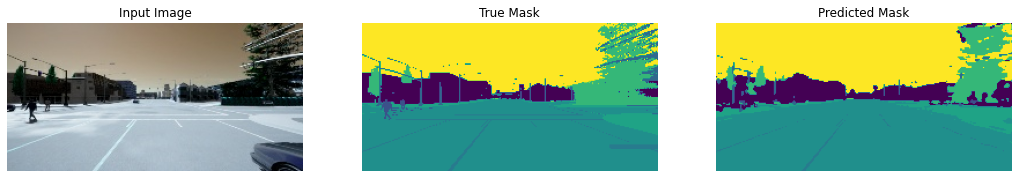

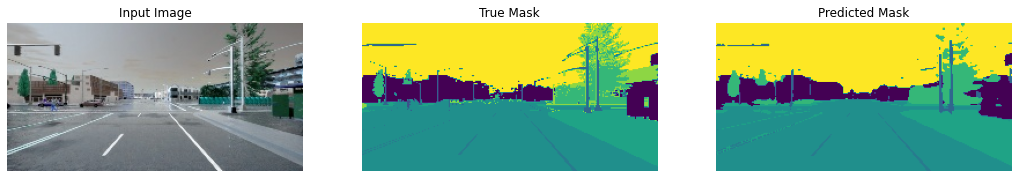

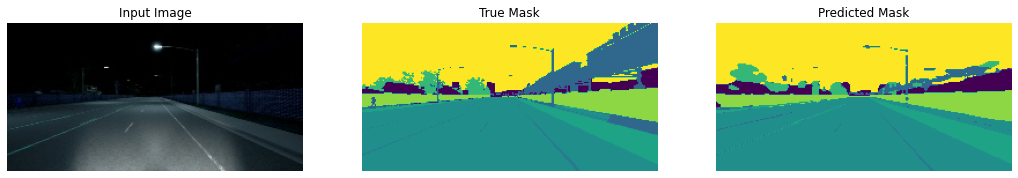

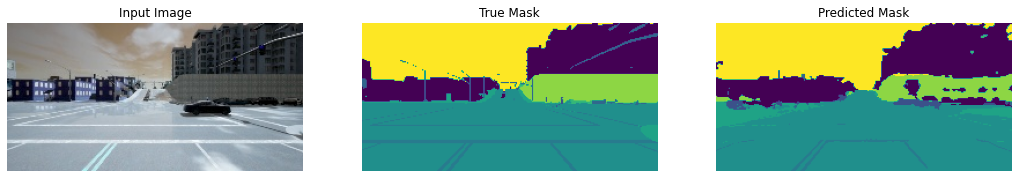

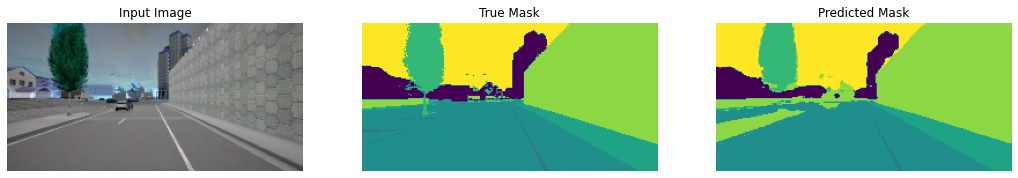

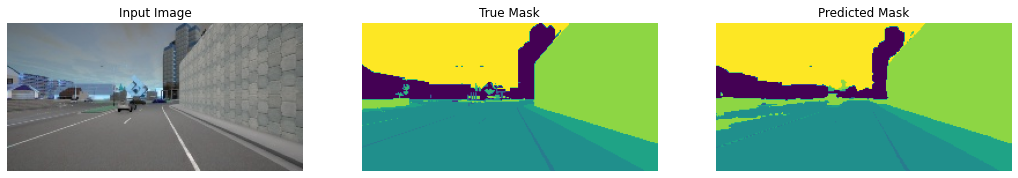

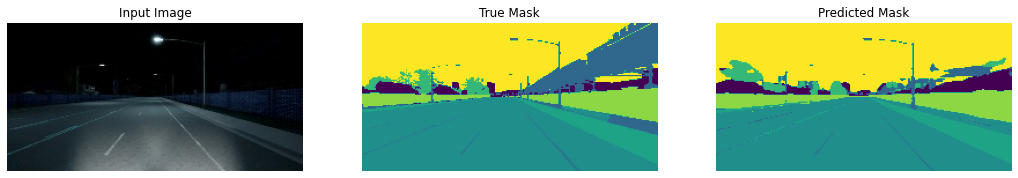

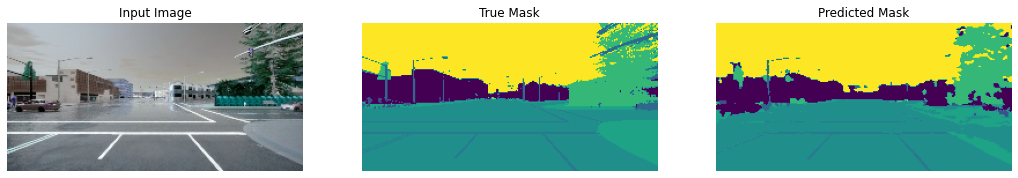

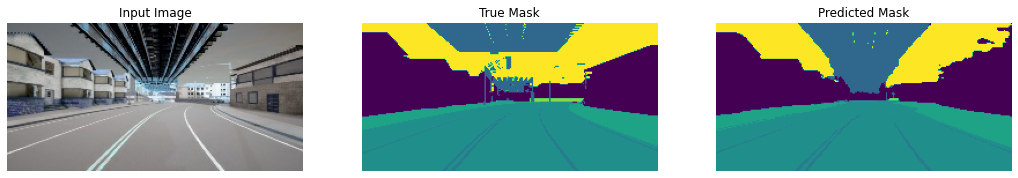

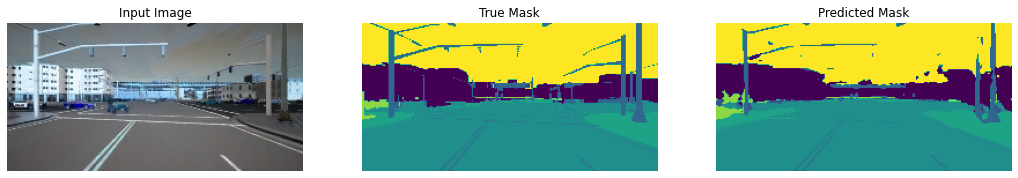

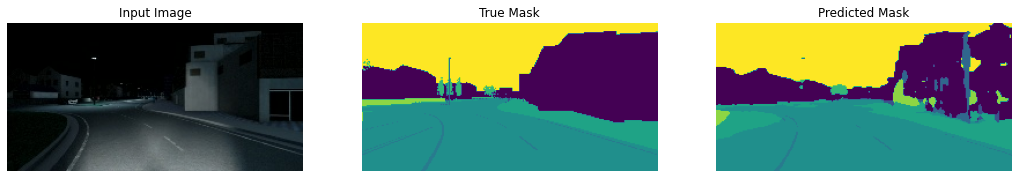

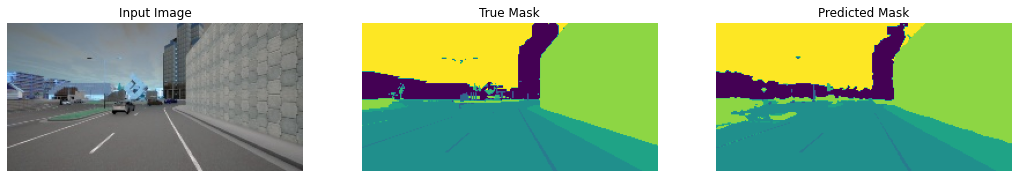

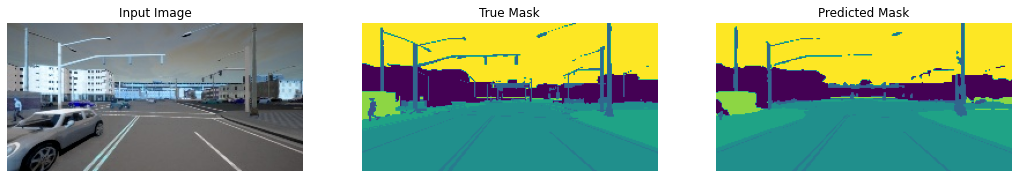

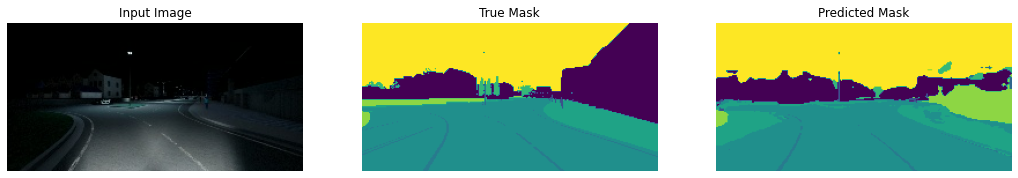

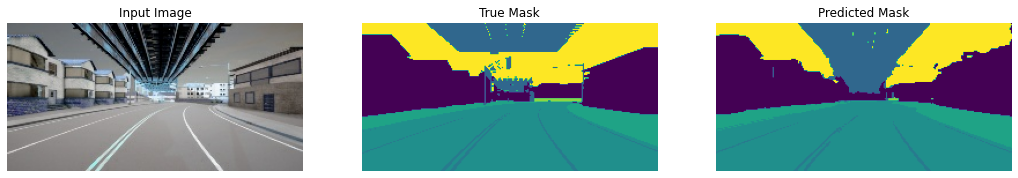

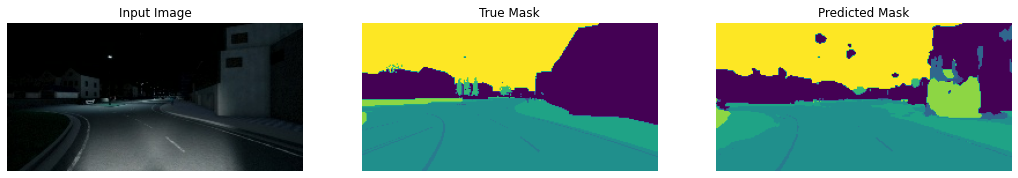

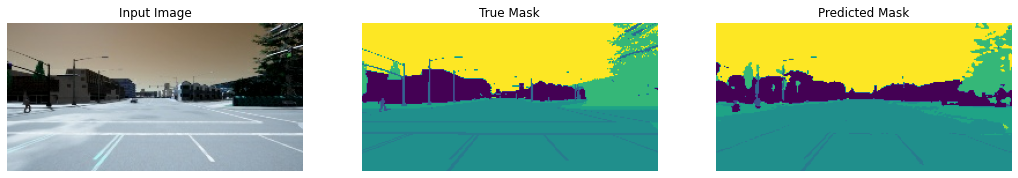

In [55]:
show_predictions(dataset['val'], num=20)

In [56]:
import glob
from sklearn.metrics import classification_report
# classification report
class_columns=['None', 'Buildings', 'Fences', 'Other', 'Pedestrians', 'Poles', 'RoadLines', 'Roads', 'Sidewalks', 'Vegetation', 'Vehicles', 'Walls', 'TrafficSigns', 'Sky']
val_imgs=np.zeros((241, 128, 256, 3))
val_depth=np.zeros((241, 128, 256, 1))
depth_imgs=np.zeros((241, 128, 256, 3))
true_output=np.zeros((241, 128, 256, 1))
if(DEPTH):
    for (i, file) in enumerate(sorted_nicely(glob.glob1('./valid/depth/', "*.png"))):
      mask = tf.io.read_file('./valid/depth/'+file)
      mask = tf.image.decode_jpeg(mask, channels=1)
      val_depth[i] = tf.image.convert_image_dtype(mask, tf.uint8)
    
for (i, file) in enumerate(sorted_nicely(glob.glob1('./valid/input/', "*.jpg"))):
  val_imgs[i]=plt.imread('./valid/input/'+file)
  
for (i, file) in enumerate(sorted_nicely(glob.glob1('./valid/output/', "*.png"))):
  #depth_imgs[i]=np.reshape(plt.imread('./valid/depth/'+file), (128, 128, 3))
  mask = tf.io.read_file('./valid/output/'+file)
  mask = tf.image.decode_jpeg(mask, channels=1)
  true_output[i] = tf.image.convert_image_dtype(mask, tf.uint8)

if(DEPTH):
    print(classification_report(np.reshape(true_output, (-1)), np.reshape(np.argmax(custom_model.predict({'input_img': val_imgs, 'input_depth': val_depth}), axis=-1), (-1)), target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']))
else:
    print(classification_report(np.reshape(true_output, (-1)), np.reshape(np.argmax(custom_model.predict(val_imgs), axis=-1), (-1)), target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']))

C:\Users\infoa\anaconda3\envs\py3.7\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\infoa\anaconda3\envs\py3.7\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\infoa\anaconda3\envs\py3.7\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\infoa\anaconda3\envs\

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.20      0.28      0.23   1119605
           2       0.00      0.00      0.00      7276
           3       0.07      0.24      0.11    430251
           4       0.01      0.01      0.01    117647
           5       0.55      0.45      0.49   2890696
           6       0.03      0.00      0.01    438158
           7       0.03      0.14      0.05    228331
           8       0.14      0.13      0.13    555764
           9       0.00      0.00      0.00       126
          10       0.47      0.20      0.28   2109234

    accuracy                           0.28   7897088
   macro avg       0.14      0.13      0.12   7897088
weighted avg       0.37      0.28      0.31   7897088



C:\Users\infoa\anaconda3\envs\py3.7\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\infoa\anaconda3\envs\py3.7\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
import time
# runtime measurement
start_time = time.time()
custom_model.evaluate(dataset['val'], steps=VALIDATION_STEPS)
print("--- %s seconds ---" % ((time.time() - start_time))/)

7/7 [==============================] - 1s 52ms/step - loss: 0.6584 - accuracy: 0.8828
--- 0.6409318447113037 seconds ---


In [58]:
if(DEPTH):
    y_pred=np.reshape(np.argmax(custom_model.predict({'input_img': val_imgs[4:5], 'input_depth': val_depth[4:5]}), axis=-1), (-1))
else:
    y_pred=np.reshape(np.argmax(custom_model.predict(val_imgs[3:4]), axis=-1), (-1))
y_true=np.reshape(true_output[4], -1)

true_positive=np.zeros((14))
false_positive=np.zeros((14))
false_negative=np.zeros((14))

iou=np.zeros((14))


for idx in range(y_pred.shape[0]):
  if(y_true[idx]==y_pred[idx]):
    true_positive[int(y_true[idx])]+=1
  else:
    false_positive[int(y_pred[idx])]+=1
    false_negative[int(y_true[idx])]+=1

iou=true_positive/(true_positive+false_positive+false_negative)
print(iou) # individual iou scores

[0.         0.02518319        nan        nan 0.         0.04932009
 0.00806452 0.25558275 0.00713719 0.                nan 0.00885609
        nan 0.06037666]


C:\Users\infoa\anaconda3\envs\py3.7\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
